# Initialize

In [3]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torchinfo import summary

from models.Transformer import ViTforEEG
from prepare_data import get_raw_dataloader, get_sub1_dataloader, get_frequency_dataloader, get_time_series_dataloader
from utils.training import best_torch_device, train

/Users/muhanz/anaconda3/envs/147fn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# torch.manual_seed(3407)
torch.manual_seed(0)
np.random.seed(0)

In [5]:
%load_ext autoreload
%autoreload 2

## Constants

In [6]:
DEVICE = best_torch_device()
RAW = "raw"
SUB1 = "sub1"
FREQ = "frequency"

## Load Data

In [7]:
train_data = {}
valid_data = {}
test_data = {}

### Raw Data

In [8]:
train_data[RAW], valid_data[RAW], test_data[RAW] = get_raw_dataloader()

In [9]:
print("Training set shape:", train_data[RAW].dataset.X.shape)
print("Validation set shape:", valid_data[RAW].dataset.X.shape)
print("Test set shape:", test_data[RAW].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


### Sub1 Data

In [10]:
train_data[SUB1], valid_data[SUB1], test_data[SUB1] = get_sub1_dataloader()

In [11]:
print("Training set shape:", train_data[SUB1].dataset.X.shape)
print("Validation set shape:", valid_data[SUB1].dataset.X.shape)
print("Test set shape:", test_data[SUB1].dataset.X.shape)

Training set shape: (199, 22, 1000)
Validation set shape: (38, 22, 1000)
Test set shape: (50, 22, 1000)


### Frequency Data

In [12]:
train_data[FREQ], valid_data[FREQ], test_data[FREQ] = get_frequency_dataloader()

In [13]:
print("Training set shape:", train_data[FREQ].dataset.X.shape)
print("Validation set shape:", valid_data[FREQ].dataset.X.shape)
print("Test set shape:", test_data[FREQ].dataset.X.shape)

Training set shape: (1777, 22, 1000)
Validation set shape: (338, 22, 1000)
Test set shape: (443, 22, 1000)


# Model

In [17]:
test_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.5,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)
test_model.forward(torch.rand(2, 22, 1000))
summary(test_model, input_size=(1, 22, 1000), device=DEVICE)

Layer (type:depth-idx)                        Output Shape              Param #
ViTforEEG                                     [1, 4]                    32,128
├─Linear: 1-1                                 [1, 500, 64]              2,880
├─TransformerEncoder: 1-2                     [1, 501, 64]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 501, 64]              25,216
├─Sequential: 1-3                             [1, 4]                    --
│    └─Linear: 2-2                            [1, 4]                    260
│    └─Softmax: 2-3                           [1, 4]                    --
Total params: 60,484
Trainable params: 28,420
Non-trainable params: 32,064
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.09
Forward/backward pass size (MB): 1.28
Params size (MB): 0.05
Estimated Total Size (MB): 1.42

# Training

## Raw Data
Train on raw data, evaluate on raw data

In [43]:
raw_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[RAW],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/transformer",
    cp_filename="raw.pt",
    n_epochs=200,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.260355 train_acc=0.238042 val_loss=0.024709 train_loss=0.021991
Validation loss decreased (inf --> 0.024709).  Saving model ...
[Epoch 1] val_acc=0.218935 train_acc=0.252673 val_loss=0.024742 train_loss=0.021881
EarlyStopping counter: 1 out of 30
[Epoch 2] val_acc=0.260355 train_acc=0.247046 val_loss=0.024585 train_loss=0.021935
Validation loss decreased (0.024709 --> 0.024585).  Saving model ...
[Epoch 3] val_acc=0.213018 train_acc=0.265053 val_loss=0.024655 train_loss=0.021857
EarlyStopping counter: 1 out of 30
[Epoch 4] val_acc=0.218935 train_acc=0.257175 val_loss=0.024608 train_loss=0.021835
EarlyStopping counter: 2 out of 30
[Epoch 5] val_acc=0.257396 train_acc=0.261677 val_loss=0.024571 train_loss=0.021812
Validation loss decreased (0.024585 --> 0.024571).  Saving model ...
[Epoch 6] val_acc=0.292899 train_acc=0.284750 val_loss=0.024392 train_loss=0.021751
Validation loss decreased (0.024571 --> 0.024392).  Saving model ...
[Epoch 7] val_acc=

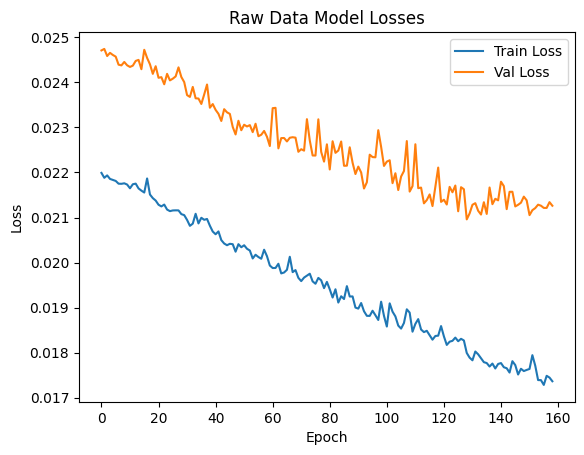

In [44]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

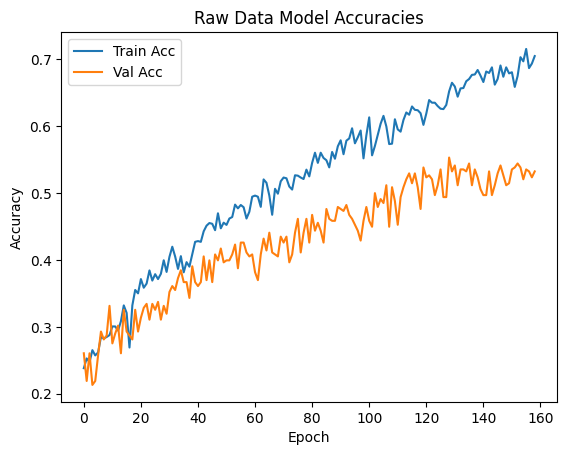

In [45]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [46]:
# Load best model and test
raw_model = torch.load("models/transformer/raw.pt")
raw_model.to(DEVICE)
raw_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=44, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [47]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.5214


In [48]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.4800


## Subject 1 Only    

In [29]:
sub1_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(sub1_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=sub1_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[SUB1],
    val_data=valid_data[SUB1],
    early_stopping_patience=50,
    cp_path="models/transformer",
    cp_filename="sub1.pt",
    n_epochs=300,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.236842 train_acc=0.206030 val_loss=0.036951 train_loss=0.028636
Validation loss decreased (inf --> 0.036951).  Saving model ...
[Epoch 1] val_acc=0.236842 train_acc=0.301508 val_loss=0.036757 train_loss=0.027558
Validation loss decreased (0.036951 --> 0.036757).  Saving model ...
[Epoch 2] val_acc=0.236842 train_acc=0.271357 val_loss=0.036747 train_loss=0.027889
Validation loss decreased (0.036757 --> 0.036747).  Saving model ...
[Epoch 3] val_acc=0.236842 train_acc=0.271357 val_loss=0.036743 train_loss=0.027905
Validation loss decreased (0.036747 --> 0.036743).  Saving model ...
[Epoch 4] val_acc=0.210526 train_acc=0.206030 val_loss=0.037050 train_loss=0.028173
EarlyStopping counter: 1 out of 50
[Epoch 5] val_acc=0.210526 train_acc=0.326633 val_loss=0.036941 train_loss=0.027706
EarlyStopping counter: 2 out of 50
[Epoch 6] val_acc=0.210526 train_acc=0.271357 val_loss=0.036534 train_loss=0.027944
Validation loss decreased (0.036743 --> 0.036534).  S

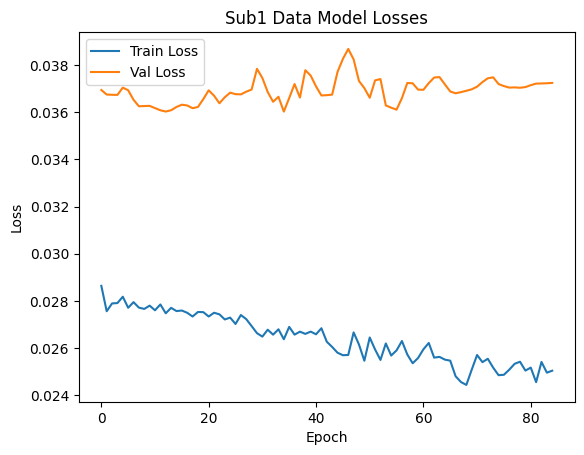

In [30]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Sub1 Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

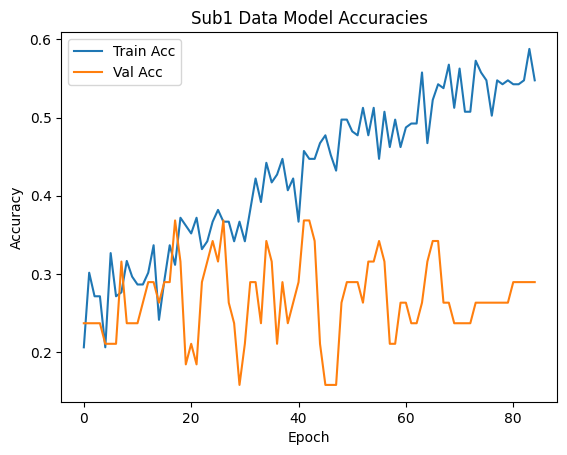

In [31]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Sub1 Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [32]:
# Load best model and test
sub1_model = torch.load("models/transformer/sub1.pt")
sub1_model.to(DEVICE)
sub1_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=44, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [33]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[SUB1]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[SUB1].dataset)
print("Train on sub1 data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on sub1 data
Test Acc: 0.3200


In [34]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = sub1_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on sub1 data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on sub1 data, evaluate on raw data
Test Acc: 0.2731


## Frequency Filtering Data

In [19]:
freq_model = ViTforEEG(input_dim=(22, 1000),
                      out_dim=4,
                      n_patches=500,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)

optimizer = torch.optim.Adam(freq_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5, verbose=True)

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=freq_model,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_func=nn.CrossEntropyLoss(),
    train_data=train_data[FREQ],
    val_data=valid_data[RAW],
    early_stopping_patience=30,
    cp_path="models/transformer",
    cp_filename="freq.pt",
    n_epochs=200,
    show_progress_bar=False,
)

Using device: mps
[Epoch 0] val_acc=0.248521 train_acc=0.255487 val_loss=0.024608 train_loss=0.021936
Validation loss decreased (inf --> 0.024608).  Saving model ...
[Epoch 1] val_acc=0.281065 train_acc=0.251548 val_loss=0.024561 train_loss=0.021891
Validation loss decreased (0.024608 --> 0.024561).  Saving model ...
[Epoch 2] val_acc=0.269231 train_acc=0.255487 val_loss=0.024549 train_loss=0.021895
Validation loss decreased (0.024561 --> 0.024549).  Saving model ...
[Epoch 3] val_acc=0.289941 train_acc=0.261114 val_loss=0.024497 train_loss=0.021842
Validation loss decreased (0.024549 --> 0.024497).  Saving model ...
[Epoch 4] val_acc=0.239645 train_acc=0.262240 val_loss=0.024546 train_loss=0.021858
EarlyStopping counter: 1 out of 30
[Epoch 5] val_acc=0.278107 train_acc=0.244795 val_loss=0.024550 train_loss=0.021867
EarlyStopping counter: 2 out of 30
[Epoch 6] val_acc=0.289941 train_acc=0.279122 val_loss=0.024484 train_loss=0.021831
Validation loss decreased (0.024497 --> 0.024484).  S

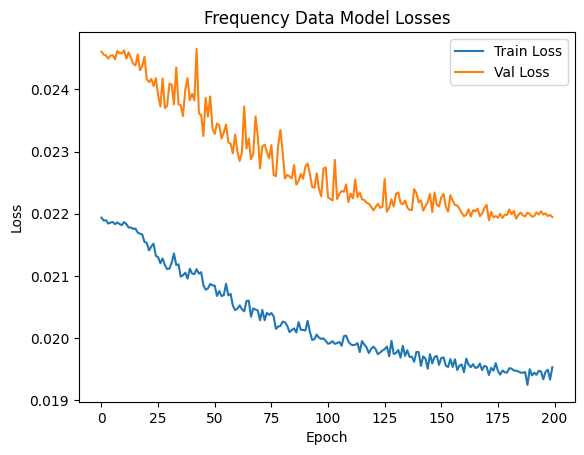

In [20]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Frequency Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

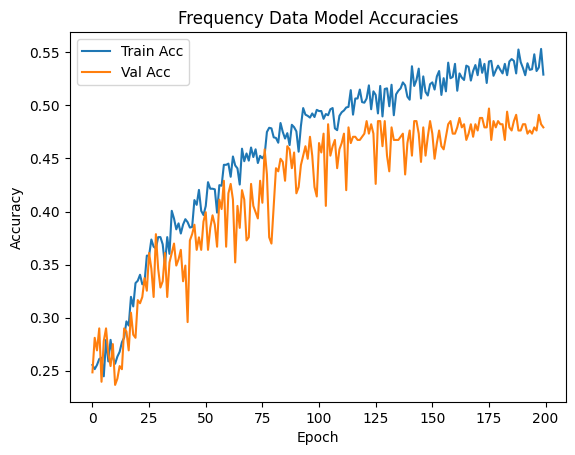

In [21]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Frequency Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [22]:
# Load best model and test
freq_model = torch.load("models/transformer/freq.pt")
freq_model.to(DEVICE)
freq_model.eval()

ViTforEEG(
  (lin_emb): Linear(in_features=44, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=64, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (mlp): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [23]:
# Evaluate on frequency data
test_acc = 0
with torch.no_grad():
    for X, y in test_data[RAW]:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_pred = freq_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_data[RAW].dataset)
print("Train on frequency data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on frequency data, evaluate on raw data
Test Acc: 0.4831


## Time Series

In [50]:
time_slots = [50, 100, 150, 200, 250, 500, 750, 1000]

In [54]:
valid_acc = {}
test_acc = {}

for ts in time_slots:
    print(f"Training for time slots: {ts}...")
    
    train_data, valid_data, test_data = get_time_series_dataloader(ts)
    
    time_model = ViTforEEG(input_dim=(22, ts),
                      out_dim=4,
                      n_patches=10,
                      hidden_dims=64,
                      num_heads=8,
                      ff_dim=64,
                      dropout=0.3,
                      num_layers=1,
                      device=DEVICE).to(DEVICE)
    
    optimizer = torch.optim.Adam(time_model.parameters(), lr=0.001, weight_decay=1e-03)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    _ = train(
        model=time_model,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_func=nn.CrossEntropyLoss(),
        train_data=train_data,
        val_data=valid_data,
        early_stopping_patience=20,
        cp_path="models/transformer",
        cp_filename=f"time_{ts}.pt",
        n_epochs=150,
        show_progress_bar=False,
        verbose=False,
    )
    
    # Load best model and test
    time_model = torch.load(f"models/transformer/time_{ts}.pt")
    time_model.to(DEVICE)
    time_model.eval()
    
    # Evaluate validation accuracies
    valid_acc[ts] = 0
    with torch.no_grad():
        for X, y in valid_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            valid_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    valid_acc[ts] /= len(valid_data.dataset)
    
    # Evaluate test accuracies
    test_acc[ts] = 0
    with torch.no_grad():
        for X, y in test_data:
            X, y = X.to(DEVICE), y.to(DEVICE)
            y_pred = time_model(X)
            test_acc[ts] += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
    test_acc[ts] /= len(test_data.dataset)
    
    print(f"Time slots: {ts}, Valid Acc: {valid_acc[ts]:.4f}, Test Acc: {test_acc[ts]:.4f}")

Training for time slots: 50...
Using device: mps
Time slots: 50, Valid Acc: 0.3876, Test Acc: 0.3770
Training for time slots: 100...
Using device: mps
Time slots: 100, Valid Acc: 0.4142, Test Acc: 0.3521
Training for time slots: 150...
Using device: mps
Time slots: 150, Valid Acc: 0.3343, Test Acc: 0.3363
Training for time slots: 200...
Using device: mps
Time slots: 200, Valid Acc: 0.3580, Test Acc: 0.2980
Training for time slots: 250...
Using device: mps
Time slots: 250, Valid Acc: 0.3787, Test Acc: 0.3273
Training for time slots: 500...
Using device: mps
Time slots: 500, Valid Acc: 0.2959, Test Acc: 0.2957
Training for time slots: 750...
Using device: mps
Time slots: 750, Valid Acc: 0.3521, Test Acc: 0.3160
Training for time slots: 1000...
Using device: mps
Time slots: 1000, Valid Acc: 0.3136, Test Acc: 0.2799


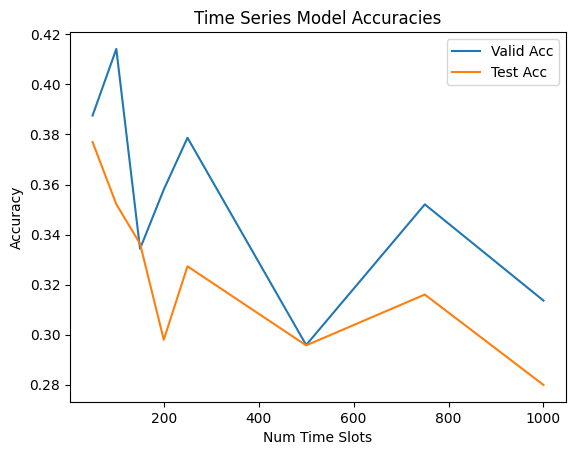

In [55]:
plt.plot(valid_acc.keys(), valid_acc.values(), label="Valid Acc")
plt.plot(test_acc.keys(), test_acc.values(), label="Test Acc")
plt.legend()
plt.title("Time Series Model Accuracies")
plt.xlabel("Num Time Slots")
plt.ylabel("Accuracy")
plt.show()